## Tree Models

In [1]:
import time
import json
from tqdm import tqdm
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from features import feature_pipeline

In [2]:
import graphviz
import re
from sklearn.tree import export_graphviz

# From DSCI 571 Lab 1 Solutions
def display_tree(feature_names, tree, save=False, save_name="tree"):
    """ For binary classification only """
    dot = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=tree.classes_.astype(str),
        impurity=False,
    )
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub("(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])", "", dot)
    dot = re.sub("(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n", "", dot)
    if save:
        graph = graphviz.Source(dot)
        graph.render(save_name)
    return graphviz.Source(dot)

#### Data Loading

In [3]:
with open("../data/train_features.json", "r", encoding="utf-8") as f:
    train = pd.DataFrame(json.load(f))
with open("../data/val_features.json", "r", encoding="utf-8") as f:
    val = pd.DataFrame(json.load(f))

In [4]:
X_train = train.iloc[:, 1:-1]
y_train = train["level"].tolist()
X_val = val.iloc[:, 1:-1]
y_val = val["level"].tolist()

In [5]:
print(
    f"All features:\n{list(X_train.columns)}\n\nNumber of features: {len(X_train.columns)}"
)

All features:
['total_tokens', 'total_tokens_w/o_stopwords', 'avg_sent_length', 'proportion_of_A_level_tokens', 'proportion_of_A_level_types', 'num_connectives', 'logical_operator_density', 'pronoun_density', 'type_token_ratio', 'avg_rank_of_lemmas_in_freq_list', 'fernandez_huerta_score', 'syllables_per_sentence', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'EOL', 'SPACE', 'CONTENT', 'FUNCTION']

Number of features: 34


In [6]:
print(X_train)

     total_tokens  total_tokens_w/o_stopwords  avg_sent_length  \
0             293                         124        22.538462   
1            1803                         694        11.967105   
2             299                         132         7.475000   
3            2153                         869        61.514286   
4            1621                         654         9.210227   
..            ...                         ...              ...   
272            76                          34        25.333333   
273           196                          83        28.000000   
274           203                          86        25.375000   
275           401                         193        21.105263   
276           358                         160        27.538462   

     proportion_of_A_level_tokens  proportion_of_A_level_types  \
0                        0.346774                     0.239130   
1                        0.358790                     0.250000   
2        

In [7]:
print(y_train)  # Training for 5 level classification

['A2', 'A2', 'A1', 'A2', 'A1', 'A2', 'A1', 'A2', 'A2', 'A1', 'A1', 'A2', 'A1', 'A1', 'A1', 'A2', 'A2', 'A1', 'A2', 'A1', 'A1', 'A2', 'A1', 'A1', 'A2', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A2', 'A2', 'A2', 'A1', 'A1', 'A2', 'A2', 'A1', 'A2', 'A1', 'A1', 'A1', 'A2', 'A2', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A2', 'A1', 'A2', 'A2', 'A2', 'A1', 'A1', 'A2', 'A1', 'A1', 'A2', 'A1', 'A1', 'A1', 'A1', 'A1', 'A2', 'A2', 'A1', 'A2', 'A1', 'A1', 'A1', 'A2', 'A1', 'A2', 'A2', 'A1', 'A2', 'A2', 'A1', 'A2', 'A1', 'A1', 'A2', 'A1', 'A2', 'A2', 'A1', 'A1', 'A2', 'A1', 'A2', 'A1', 'A1', 'A2', 'A1', 'A1', 'A1', 'A1', 'A2', 'A1', 'A1', 'A2', 'A2', 'A1', 'A1', 'A1', 'A2', 'A1', 'A1', 'A1', 'A1', 'A2', 'A2', 'A2', 'A2', 'A1', 'A2', 'A2', 'A1', 'A2', 'A2', 'A1', 'A2', 'A1', 'A1', 'A2', 'A1', 'A2', 'A1', 'A2', 'A1', 'A1', 'A1', 'A2', 'A1', 'B1', 'B', 'B', 'B1', 'B2', 'B2', 'B', 'B1', 'B', 'B2', 'B', 'B', 'B', 'B1', 'B', 'B', 'B1', 'B1', 'B2', 'B2', 'B', 'B2', 'B', 'B2', 'B1', 'B', 'B1', 'B1', 'B2

#### Determine the appropriate depth for the decision tree classifier

In [8]:
depths = range(1, 25)

train_accuracies = []
val_accuracies = []

for depth in depths:
    predictions = []
    tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    predicted_y_val = tree.predict(X_val, y_val)
    val_accuracies.append(accuracy_score(y_val, predicted_y_val))

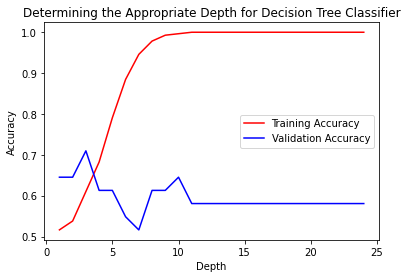

In [9]:
import matplotlib.pyplot as plt

plt.plot(depths, train_accuracies, "r")
plt.plot(depths, val_accuracies, "b")
plt.title("Determining the Appropriate Depth for Decision Tree Classifier")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [10]:
depth = 3
print(f"Training decision tree classifier with max depth of {depth} ...\n")
tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
tree.fit(X_train, y_train)
print("Training accuracy %0.3f" % (tree.score(X_train, y_train)))

Training decision tree classifier with max depth of 3 ...

Training accuracy 0.610


In [11]:
predicted_y_val = tree.predict(X_val, y_val)
print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))

Validation accuracy 0.710


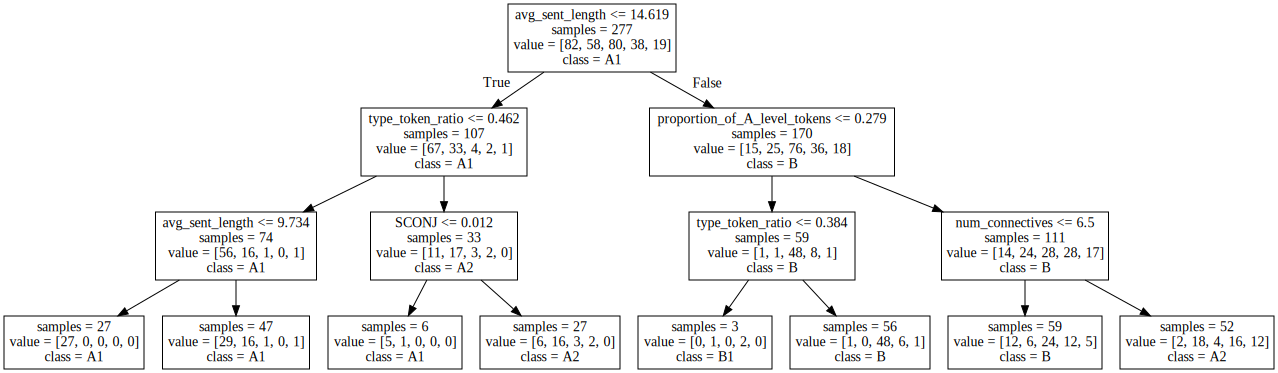

In [12]:
display_tree(X_train.columns, tree, save=True)

#### Let's try some more advanced tree models too

In [13]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [14]:
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=123),
}

for (name, model) in classifiers.items():
    print(name)
    start = time.time()
    model.fit(X_train, y_train)
    print(f"\tTrained in {time.time() - start} seconds.")
    print("\tTraining accuracy %0.3f" % (model.score(X_train, y_train)))
    predicted_y_val = model.predict(X_val)
    print("\tValidation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))
    print()

Random Forest
	Trained in 0.6205108165740967 seconds.
	Training accuracy 1.000
	Validation accuracy 0.774

XGBoost


C:\Users\rsss9\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:11:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
	Trained in 1.109534502029419 seconds.
	Training accuracy 1.000
	Validation accuracy 0.742

LightGBM
	Trained in 0.4604361057281494 seconds.
	Training accuracy 1.000
	Validation accuracy 0.677

CatBoost
	Trained in 32.946266889572144 seconds.
	Training accuracy 1.000
	Validation accuracy 0.742



#### The above was all using 5 levels of classification. Now let's try just A-B distinction.

In [15]:
y_train = []
for lvl in train["level"].tolist():
    y_train.append(lvl[0])
y_val = []
for lvl in val["level"].tolist():
    y_val.append(lvl[0])

In [16]:
print(
    f"All features:\n{list(X_train.columns)}\n\nNumber of features: {len(X_train.columns)}"
)

All features:
['total_tokens', 'total_tokens_w/o_stopwords', 'avg_sent_length', 'proportion_of_A_level_tokens', 'proportion_of_A_level_types', 'num_connectives', 'logical_operator_density', 'pronoun_density', 'type_token_ratio', 'avg_rank_of_lemmas_in_freq_list', 'fernandez_huerta_score', 'syllables_per_sentence', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'EOL', 'SPACE', 'CONTENT', 'FUNCTION']

Number of features: 34


In [17]:
print(X_train)

     total_tokens  total_tokens_w/o_stopwords  avg_sent_length  \
0             293                         124        22.538462   
1            1803                         694        11.967105   
2             299                         132         7.475000   
3            2153                         869        61.514286   
4            1621                         654         9.210227   
..            ...                         ...              ...   
272            76                          34        25.333333   
273           196                          83        28.000000   
274           203                          86        25.375000   
275           401                         193        21.105263   
276           358                         160        27.538462   

     proportion_of_A_level_tokens  proportion_of_A_level_types  \
0                        0.346774                     0.239130   
1                        0.358790                     0.250000   
2        

In [18]:
print(y_train)  # Training for A-B classification

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',

#### Determine the appropriate depth for the decision tree classifier

In [19]:
depths = range(1, 25)

train_accuracies = []
val_accuracies = []

for depth in depths:
    predictions = []
    tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    predicted_y_val = tree.predict(X_val, y_val)
    val_accuracies.append(accuracy_score(y_val, predicted_y_val))

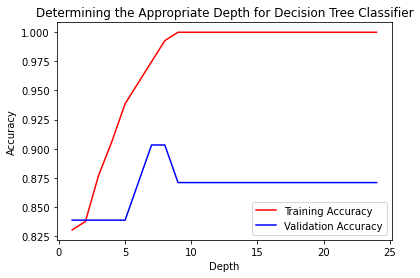

In [20]:
import matplotlib.pyplot as plt

plt.plot(depths, train_accuracies, "r")
plt.plot(depths, val_accuracies, "b")
plt.title("Determining the Appropriate Depth for Decision Tree Classifier")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [21]:
depth = 8
print(f"Training decision tree classifier with max depth of {depth} ...\n")
tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
tree.fit(X_train, y_train)
print("Training accuracy %0.3f" % (tree.score(X_train, y_train)))

Training decision tree classifier with max depth of 8 ...

Training accuracy 0.993


In [22]:
predicted_y_val = tree.predict(X_val, y_val)
print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))

Validation accuracy 0.903


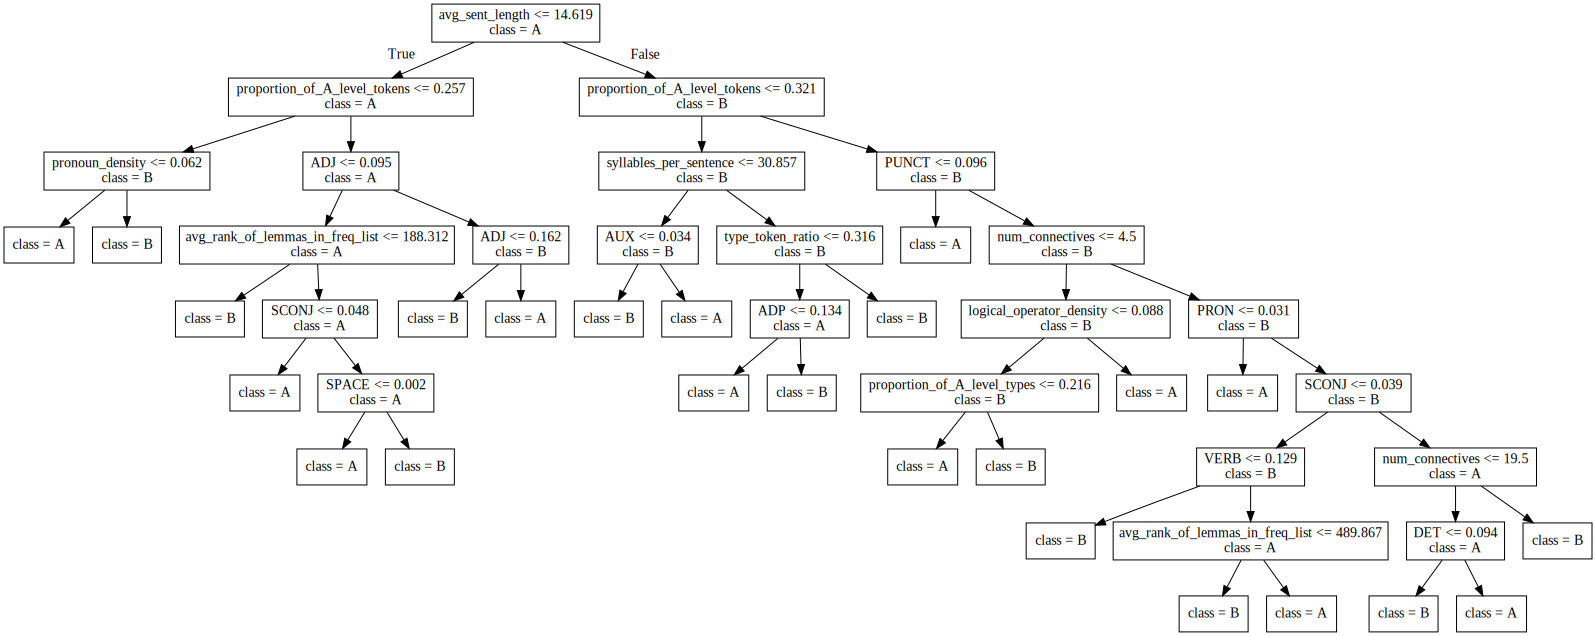

In [23]:
display_tree(X_train.columns, tree, save=True)

#### Advanced tree models

In [24]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [25]:
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=123),
}

for (name, model) in classifiers.items():
    print(name)
    start = time.time()
    model.fit(X_train, y_train)
    print(f"\tTrained in {time.time() - start} seconds.")
    print("\tTraining accuracy %0.3f" % (model.score(X_train, y_train)))
    predicted_y_val = model.predict(X_val)
    print("\tValidation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))
    print()

Random Forest
	Trained in 0.30232810974121094 seconds.
	Training accuracy 1.000
	Validation accuracy 0.903

XGBoost
[13:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
	Trained in 0.1409759521484375 seconds.


C:\Users\rsss9\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


	Training accuracy 1.000
	Validation accuracy 0.903

LightGBM
	Trained in 0.11688470840454102 seconds.
	Training accuracy 1.000
	Validation accuracy 0.935

CatBoost
	Trained in 8.67083215713501 seconds.
	Training accuracy 1.000
	Validation accuracy 0.903

